In [75]:
%matplotlib inline
import Utilities.raster_utils as rast
import Utilities.stats_utils as stats
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats.kde import gaussian_kde
from sklearn import cluster as Kclust, metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


In [180]:
base_str = 'Imagery_Data/L8'

def multi_img_to_array(multi_image_list):
    ravel_list = map(np.ravel, multi_image_list)
    return np.array(ravel_list)

def normalize_(imgs):
    return preprocessing.normalize(imgs, norm='l2', axis=1)

#################
# Load the data #
#################

#Ground truth data
NLCD = rast.read_raster('Imagery_Data/NLCD_2011.tif')

#Get TOA reflectance for the red and NIR bands
GREEN = rast.transform_TOA(base_str, 3)
RED = rast.transform_TOA(base_str, 4)
NIR = rast.transform_TOA(base_str, 5)
SWIR = rast.transform_TOA(base_str, 6)
TIR_1 = rast.transform_sat_brightness_temp(base_str, 10)
TIR_2 = rast.transform_sat_brightness_temp(base_str, 11)

#Wide Dynamic Range Veg Index
WDRVI = rast.calc_normalized_diff(NIR, RED, alpha=0.2)
#Normalized Diff Water Index
NDWI = rast.calc_normalized_diff(GREEN, NIR, alpha=1.0)
#Normalized Impervious Surface Index
NISI_ = rast.NISI(GREEN, SWIR, NIR, TIR_1)


<matplotlib.colorbar.Colorbar instance at 0x11cd67a28>

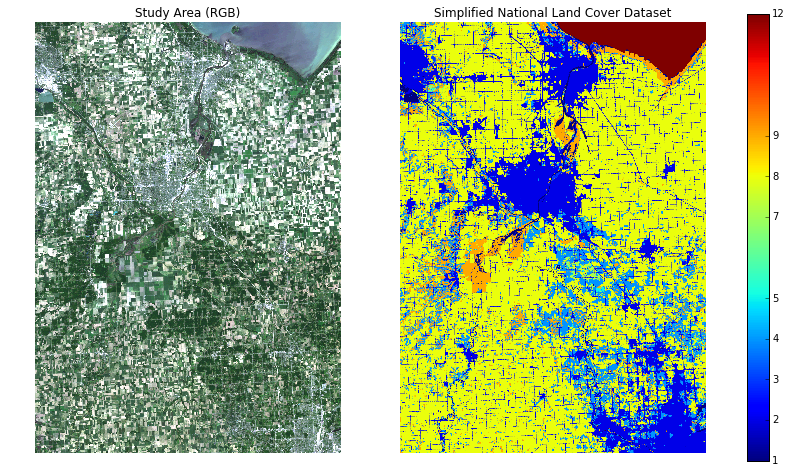

In [163]:
#######################################################
#From the NLCD FAQ: file:///Users/john/Downloads/land_use_land_cover_NLCD_mbr_3038831_01/land_use_land_cover%5Cnlcd_2011_faq.html
#
#The simplified land cover types are:
# - 1: Water
# - 2: Developed land
# - 3: Barren
# - 4: Forest
# - 5: Scrub
# - 7: Grassland
# - 8: Agricultural Land
# - 9: Wetland
# - 12: No Data (Lake Huron)
#######################################################

def group_NLCD(array):
    return (array / 10).astype(int)

simple_NLCD = group_NLCD(NLCD)

plt.figure(figsize = (15,10))
image = rast.get_multiband_array(base_str, bn=(4,3,2), enhance='stretch_histogram', gamma=1.25, percentile=95)
ax1 = plt.subplot(121)
ax1.imshow(image);
ax1.set_title('Study Area (RGB)');
ax1.set_axis_off()

ax2 = plt.subplot(122)
ax2.imshow(simple_NLCD, cmap='Set2');
ax2.set_title('Simplified National Land Cover Dataset');
ax2.set_axis_off()

#Add legend
plt.colorbar(plt.imshow(simple_NLCD), ax=[ax1, ax2], ticks=np.unique(simple_NLCD).tolist(), shrink=0.8);

#To do: Add discrete legend

### Build the Dataset

Looking at our study area, we can see a good mix of land cover types. Areas of Flint, Saginaw, and Bay City provide a good mix of developed land within the mostly agricultural area of mid-Michigan. For our modeling exercise, I will split the image in half vertically to give us spatially coherant test and training datasets.

To actually build the model, we need to take a sample from the training / test halves of the images. To do this in a way that:

* Takes the spatial structure of the data into account
* Ensures data is taken from across the whole image
* Is relativly random

we will use a sampling method known as two step sampling. The procedure is relativly straightforward:

1. Partition the image into regular grid cells
2. Randomly take `n` samples from each grid cell

See [here](http://www.lreis.ac.cn/upload/article/wjf_sampling%20review121015.pdf) for an overview of spatial sampling methods.


In [181]:
#Build the test and training datasets for our model
test = np.dstack((simple_NLCD,WDRVI, NDWI, NISI_, RED, GREEN, NIR, SWIR, TIR_1, TIR_2))[:, :850]
train = np.dstack((simple_NLCD,WDRVI, NDWI, NISI_, RED, GREEN, NIR, SWIR, TIR_1, TIR_2))[:,850:]

#NLCD value `128` is a no data value (Lake Huron far from the shore) removing from the training data
train_sample = np.array(stats.two_step_sample(train, 10000, (50,50)))
train_sample = np.delete(train_sample, np.where(train_sample[:,0]==12)[0], axis=0)
test_sample = np.array(stats.two_step_sample(test, 10000, (50,50)))


### Data Overview


Let's take a look at the distributions of the data for each of the indicies we are using in our model:
* WDRVI: Wide Dynamic Range Vegetative Index
* NDWI: Normalized Difference Water Index
* NISI: Normalized Impervious Surface Index

Each of these is meant to capture a different feature of the landscape (Vegetation, Water, Impervious surfaces), so we should expect to see some seperation between the primary land cover types.

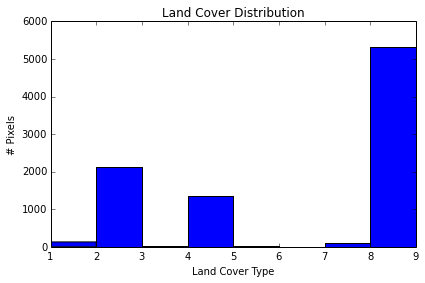

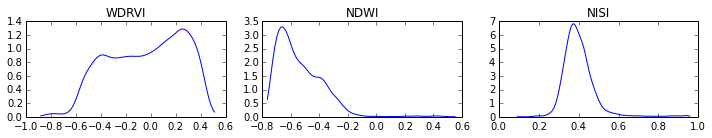

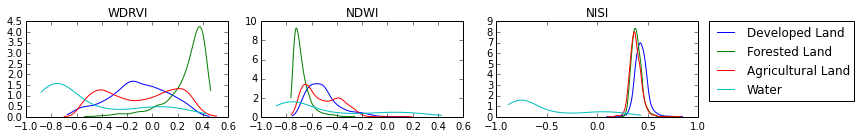

In [59]:
def subset(array, grp):
    return array[np.where(array[:,0]==grp)]

#Full Data Set Distribution
plt.hist(train_sample[:,0], 8);
plt.title('Land Cover Distribution')
plt.ylabel('# Pixels')
plt.xlabel('Land Cover Type')
plt.tight_layout()

#Data distribution for each feature
prob_dens = map(stats.density,[train_sample[:,1],train_sample[:,2],train_sample[:,3]])
plt.figure(figsize = (10,2))
ax1 = plt.subplot(131)
ax1.plot(prob_dens[0][0],prob_dens[0][1])
ax1.set_title('WDRVI')
ax2 = plt.subplot(132)
ax2.plot(prob_dens[1][0],prob_dens[1][1])
ax2.set_title('NDWI')
ax3 = plt.subplot(133)
ax3.plot(prob_dens[2][0],prob_dens[2][1])
ax3.set_title('NISI')
plt.tight_layout()

######################################
# Distributions by land cover type   #
######################################

sub_water = subset(train_sample, 1)
sub_developed = subset(train_sample, 2)
sub_forest = subset(train_sample, 4)
sub_ag = subset(train_sample, 8)

#set up the plot
plt.figure(figsize = (10,2))

#WDRVI curves
WDRVI_prob_dens = map(stats.density,[sub_developed[:,1],sub_forest[:,1],sub_ag[:,1],sub_water[:,1]])
ax1 = plt.subplot(131)
ax1.plot(WDRVI_prob_dens[0][0], WDRVI_prob_dens[0][1])
ax1.plot(WDRVI_prob_dens[1][0], WDRVI_prob_dens[1][1])
ax1.plot(WDRVI_prob_dens[2][0], WDRVI_prob_dens[2][1])
ax1.plot(WDRVI_prob_dens[3][0], WDRVI_prob_dens[3][1])
ax1.set_title('WDRVI')

#NDWI Curves
NDWI_prob_dens = map(stats.density,[sub_developed[:,2],sub_forest[:,2],sub_ag[:,2],sub_water[:,1]])
ax2 = plt.subplot(132)
ax2.plot(NDWI_prob_dens[0][0], NDWI_prob_dens[0][1])
ax2.plot(NDWI_prob_dens[1][0], NDWI_prob_dens[1][1])
ax2.plot(NDWI_prob_dens[2][0], NDWI_prob_dens[2][1])
ax2.plot(NDWI_prob_dens[3][0], NDWI_prob_dens[3][1])
ax2.set_title('NDWI')

#NISI Curves
NISI_prob_dens = map(stats.density,[sub_developed[:,3],sub_forest[:,3],sub_ag[:,3],sub_water[:,1]])
ax3 = plt.subplot(133)
ax3.plot(NISI_prob_dens[0][0], NISI_prob_dens[0][1], label='Developed Land')
ax3.plot(NISI_prob_dens[1][0], NISI_prob_dens[1][1], label='Forested Land')
ax3.plot(NISI_prob_dens[2][0], NISI_prob_dens[2][1], label='Agricultural Land')
ax3.plot(NISI_prob_dens[3][0], NISI_prob_dens[3][1], label='Water')
ax3.set_title('NISI')

ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

Looking at the breakout of each feature by the land cover type, we can see there is not a lot of seperation between the land cover types in NISI. WDRVI and NDWI are better, but not great. An interesting note: agricultural land has a bimodal distribution in both WDRVI and NDWI, possibly due to the presence of both planted and bare fields. In this area, winter wheat is a common crop- at this time of year it is already turning brown, increasing its reflectivity. 

## Predicting Land Cover

Now that we have a better understanding of the dataset, let's build a model. We will be using random forest, an ensamble model with good results on a wide range of problems. Essentially, random forest uses multiple subsets of the data to construct a series of decision trees, the results of which are averaged.

### Learn More
* [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Basic overview](http://blog.yhat.com/posts/random-forests-in-python.html) of random forest
* [Detailed discussion](http://arxiv.org/pdf/1407.7502.pdf) of random forest 

### Hyper-Parameters

There are a few hyperparameters that need to be tuned when building a random forest model, the first being how many trees to build. The first thing we will do is build a model with a varying number of trees and plot the OOB error rate.



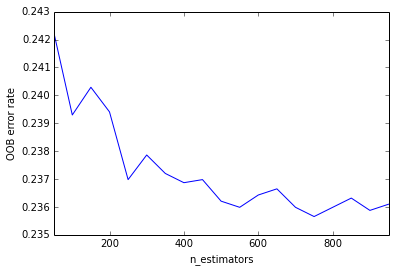

In [216]:

num_estimator = range(50,1000,50)
error_rate = []

for i in num_estimator:
    rf_model = RandomForestClassifier(n_estimators=i, criterion="entropy",oob_score=True,max_features="sqrt",random_state=53478,min_samples_split=10)
    rf_model.fit(train_sample[:,1:],train_sample[:,0])

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - rf_model.oob_score_
    error_rate.append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
xs, ys = zip(*error_rate)
plt.plot(xs, ys)

plt.xlim(min(num_estimator), max(num_estimator))
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
#plt.legend(loc="upper right")
plt.show()

Looking at the plot of OOB and number of trees in the ensamble above, it looks like there are a few places where the model has its minimum error, the smallest being about 550 trees. We will set the `n_estimators` parameter to 550 in the models below.

In [215]:
#Build a random forest model
rf_model = RandomForestClassifier(n_estimators=100, criterion="entropy",oob_score=True,max_features="sqrt",random_state=53478,min_samples_split=10)
rf_model.fit(train_sample[:,1:],train_sample[:,0])

#How well does the model perform? run it on the test data...
print 'Test Data Score: ', rf_model.score(test_sample[:,1:], test_sample[:,0])

#to do: Clean up the confusuon matrix output


Test Data Score:  0.762934782609


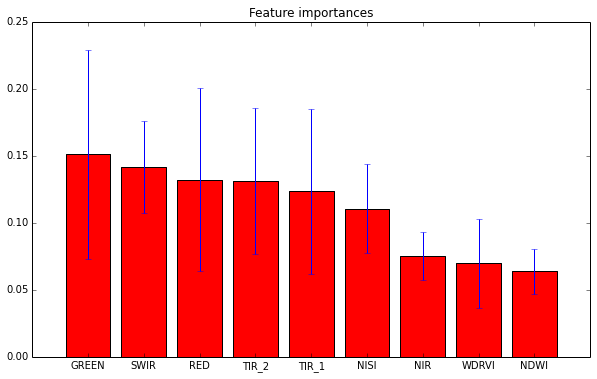

In [212]:
importances = rf_model.feature_importances_
std = np.std([t.feature_importances_ for t in rf_model.estimators_],
             axis=0)

f_names = ['WDRVI', 'NDWI', 'NISI', 'RED', 'GREEN', 'NIR', 'SWIR', 'TIR_1', 'TIR_2']
imps = [(n,i,s) for n,i,s in zip(f_names,importances, std)]
ord_imps =  sorted(imps, key=lambda x: x[1], reverse=True)


# Plot the feature importances of the forest
plt.figure(figsize = (10,6))
plt.title("Feature importances")
ax1 = plt.subplot()
ax1.bar(range(len(f_names)), [i[1] for i in ord_imps],
       color="r", yerr=[i[2] for i in ord_imps], align="center")
ax1.set_xticks(range(len(f_names)))
ax1.set_xticklabels([i[0] for i in ord_imps])

plt.show()

One importent part of evaluating model performance is to look at how importent the various features are for predicting the final class of a pixel. Our constructed features (NISI, WDRVI, and NDWI) do not look like they are very useful, with the Green, Short Wave Infrared, and Thermal bands being more powerful predictors of land cover.

## Results

Running the model on our test data gives us `score: 0.76`. This is not too bad (see more [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.score) ), given the limited feature set used in the model. The real issue with this kind of measure is that it does not give us any understanding of how the model performed on each of the classes, or where the model had difficulty distinguishing between particular classes. For this, we need to look at a confusion matrix.

In [213]:
#convenience function for showing the confusion matrix
def pad_cell(x):
    while len(x)<4:
        x = x + ' '
    return x

y_pred = rf_model.predict(test_sample[:,1:])
cm = (confusion_matrix(test_sample[:,0], y_pred)).tolist()

#print a more readable confusion matirx
labels = [1,2,3,4,5,7,8,9]

print '          Predicted'
print 'Actual'
print ' '.join(map(pad_cell,[str(l) for l in ['         ']+labels]))
print ''
for l,r in zip(labels,range(len(cm))):
    print '    ',' '.join(map(pad_cell,[str(c) for c in [l]+cm[r]]))
print ' '
print "Producer's Accuracy (%)"
print '         ',' '.join(map(pad_cell,[str(el) for el in (np.diag(cm) / (np.sum(cm, axis=0)).astype(float) *100).astype(np.uint8)]))



          Predicted
Actual
          1    2    3    4    5    7    8    9   

     1    84   1    0    4    0    0    19   21  
     2    5    879  2    25   0    0    547  10  
     3    0    2    0    0    0    0    7    1   
     4    5    39   0    584  0    0    274  19  
     5    0    0    0    4    0    0    6    0   
     7    0    7    0    7    0    0    65   4   
     8    8    312  2    80   0    0    5404 21  
     9    20   10   0    487  0    0    188  47  
 
Producer's Accuracy (%)
          68   70   0    49   0    0    83   38  


Looking at the confusion matrix above, we can see some clear issues with our model, mostly with the natural land cover classes. Agricultural land is the class with the highest accuracy (and the most pixels), giving us the average accuracy of 76%. We also do pretty well on developed land (the next largest class), but do much less well on the forset and wetland classes. 

Next, lets take a look at the map out model makes- how well does it match the actual land cover map?

In [167]:
#prepare the test area of the image for prediction by the model
pred_image = np.copy(test[:,:,0])
_x,_y = np.where(~np.isnan(test[:,:,1]))
pred_image[_x,_y] = rf_model.predict(test[_x,_y,1:])

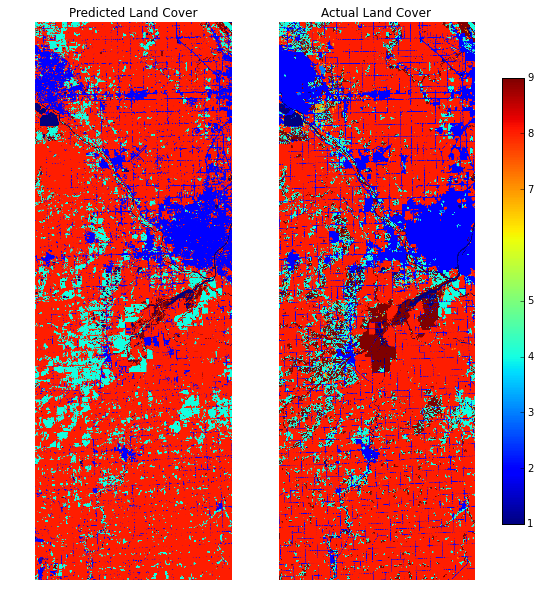

In [169]:
#plot the 1) predicted landcover 2) actual land cover

##
#To Do: set color map to the one used above, add legend
##

plt.figure(figsize = (10,10))
ax1 = plt.subplot(121)
ax1.imshow(pred_image)
ax1.set_title('Predicted Land Cover')
ax1.set_axis_off()

ax2 = plt.subplot(122)
ax2.imshow(test[:,:,0])
ax2.set_title('Actual Land Cover')
ax2.set_axis_off()

#Add legend
plt.colorbar(plt.imshow(test[:,:,0]), ax=[ax1, ax2], ticks=np.unique(test[:,:,0]).tolist(), shrink=0.8);
